# Using Linear Tree Formulations in OMLT

In this notebook we show how OMLT can be used to build different optimization formulations of linear model decision trees within Pyomo. It specifically demonstrates the following examples:<br>
1.) A linear model decision tree represented using the GDP formulation and a Big-M transformation <br>
2.) A linear model decision tree represented using the GDP formulation and a Convex Hull transformation <br>
<br>
After building the OMLT formulations, we minimize each representation of the function and compare the results.

## Library Setup
This notebook assumes you have a working Tensorflow environment in addition to necessary Python packages described here. We use Keras to train neural networks of interest for our example which requires the Python Tensorflow package. The neural networks are then formulated in Pyomo using OMLT which therefore requires working Pyomo and OMLT installations.

The required Python libraries used this notebook are as follows: <br>
- `pandas`: used for data import and management <br>
- `matplotlib`: used for plotting the results in this example
- `linear-tree`: the machine learning language we use to train our linear model decision tree
- `scikit-learn`: another machine learning language used to for the Linear Regression models
- `pyomo`: the algebraic modeling language for Python, it is used to define the optimization model passed to the solver
- `omlt`: The package this notebook demonstates. OMLT can formulate machine learning models (such as neural networks) within Pyomo

**NOTE:** This notebook also assumes you have a working MIP solver executable (e.g., CBC, Gurobi) to solve optimization problems in Pyomo. The open-source solvers CBC and IPOPT are called by default.

In [1]:
#Start by importing the following libraries
#data manipulation and plotting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rc('font', size=24)
plt.rc('axes', titlesize=24)

#linear-tree objects
from lineartree import LinearTreeRegressor
from sklearn.linear_model import LinearRegression

#pyomo for optimization
import pyomo.environ as pyo

#omlt for interfacing our neural network with pyomo
from omlt import OmltBlock
from omlt.lineartree import LinearTreeGDPFormulation, LinearTreeModel
import omlt

## Import the Data

We begin by training neural networks that learn from data given the following imported dataframe. In practice, this data could represent the output of a simulation, real sensor measurements, or some other external data source. The data contains a single input `x` and a single output `y` and contains 10,000 total samples

In [2]:
df = pd.read_csv("../data/sin_quadratic.csv",index_col=[0])

The data we use for training is plotted below (on the left figure). We also scale the training data to a mean of zero with unit standard deviation. The scaled inputs and outputs are added to the dataframe and plotted next to the original data values (on the right).

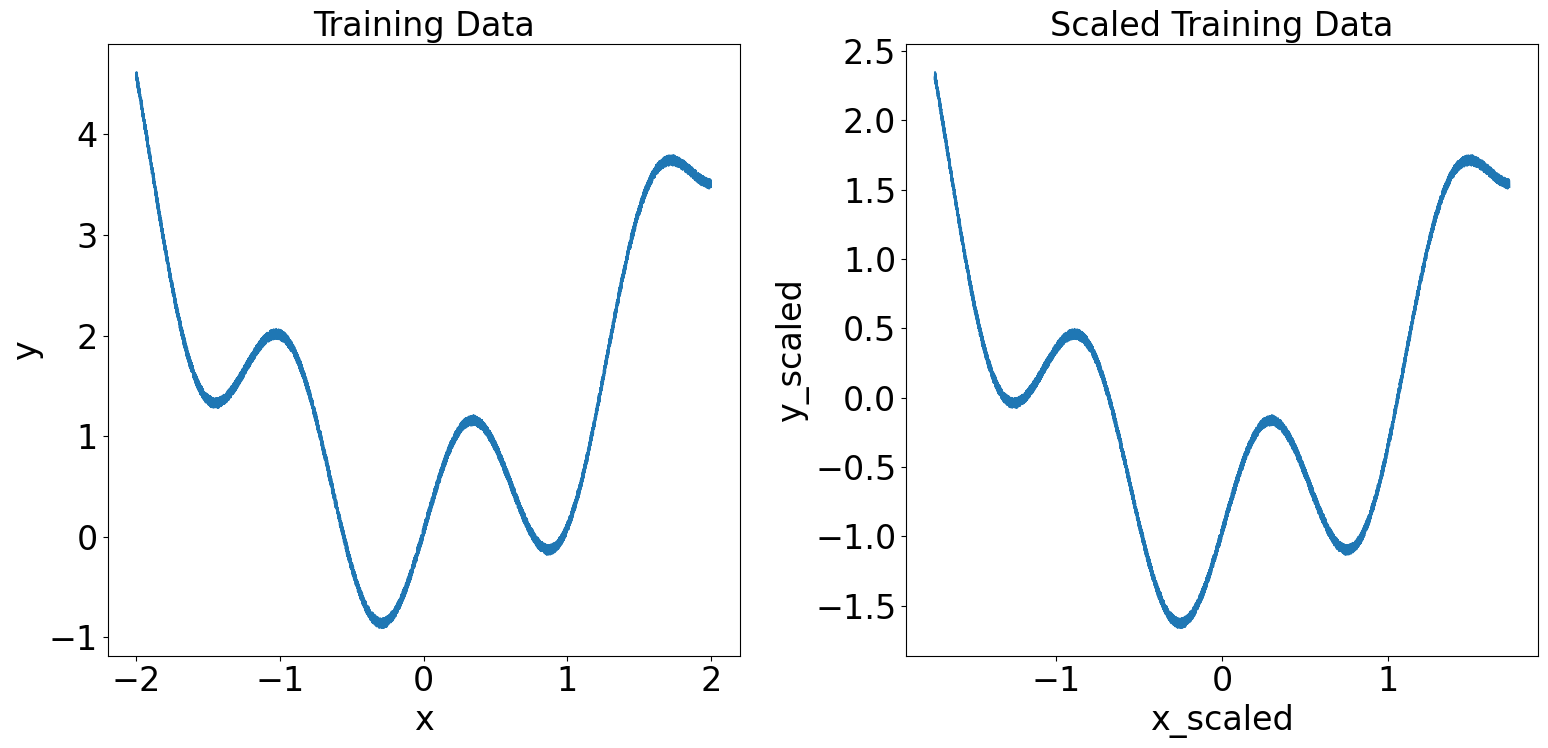

In [3]:
#retrieve input 'x' and output 'y' from the dataframe
x = df["x"]
y = df["y"]

#calculate mean and standard deviation, add scaled 'x' and scaled 'y' to the dataframe
mean_data = df.mean(axis=0)
std_data = df.std(axis=0)
df["x_scaled"] = (df['x'] - mean_data['x']) / std_data['x']
df["y_scaled"] = (df['y'] - mean_data['y']) / std_data['y']

#create plots for unscaled and scaled data
f, (ax1, ax2) = plt.subplots(1, 2,figsize = (16,8))

ax1.plot(x, y)
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_title("Training Data")

ax2.plot(df["x_scaled"], df["y_scaled"])
ax2.set_xlabel("x_scaled")
ax2.set_ylabel("y_scaled")
ax2.set_title("Scaled Training Data")

plt.tight_layout()

## Train a Linear Model Decsion Tree using the linear-tree package

In [4]:
#Build the linear-tree model
regr = LinearTreeRegressor(LinearRegression(), 
                            criterion='mse', 
                            max_bins=120, 
                            min_samples_leaf=30, 
                            max_depth=8)

In [6]:
#Data needs to be in array and reshaped
x_scaled = df["x_scaled"].to_numpy().reshape(-1,1)
y_scaled = df["y_scaled"].to_numpy().reshape(-1,1)

#train the linear tree on the scaled data
history1 = regr.fit(x_scaled,y_scaled)

## Check the predictions
Before we formulate our trained linear model decision trees in OMLT, we check to see that they adequately represent the data. While we would normally use some accuracy measure, we suffice with a visual plot of the fits.

In [7]:
#note: we calculate the unscaled output for each neural network to check the predictions
y_predict_scaled_lt = regr.predict(x_scaled)
y_predict_lt = y_predict_scaled_lt*(std_data['y']) + mean_data['y']

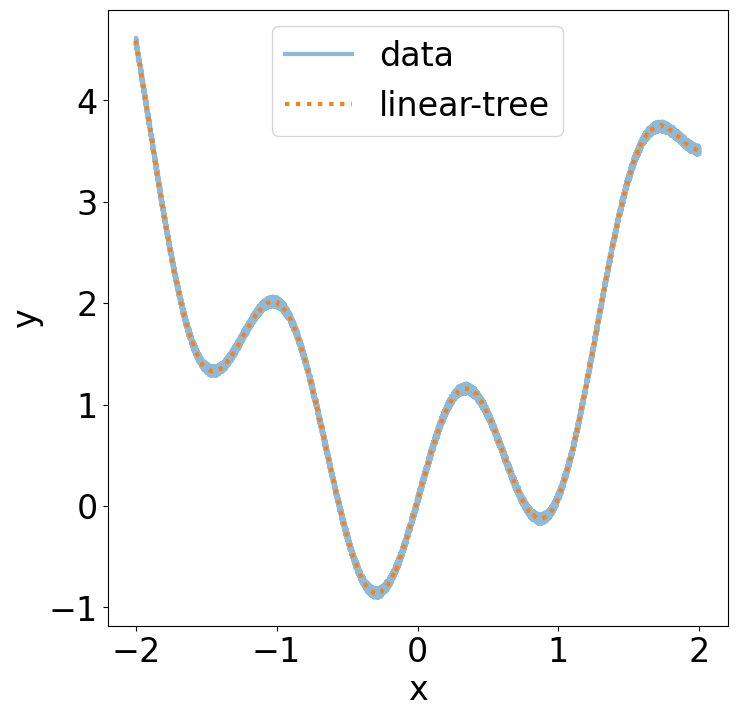

In [8]:
#create a single plot with the original data and each neural network's predictions
fig,ax = plt.subplots(1,figsize = (8,8))
ax.plot(x,y,linewidth = 3.0,label = "data", alpha = 0.5)
ax.plot(x,y_predict_lt,linewidth = 3.0,linestyle="dotted",label = "linear-tree")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()

## Solving Optimization Problems with Linear Trees using OMLT

$
\begin{align*} 
& \min_x \ \hat{y}\\
& s.t. \hat{y} = ML(x) 
\end{align*}
$

We instantiate a Pyomo `ConcreteModel` and create variables that represent the linear model decision tree input $x$ and output $\hat y$. We also create an objective function that seeks to minimize the output $\hat y$.

The example uses the following general workflow:
- Create an OMLT `LinearTreeModel` object.
- Create a Pyomo model with variables `x` and `y` where we intend to minimize `y`.
- Create an `OmltBlock`.
- Create a formulation object. Note that `LinearTreeGDPFormulation` has an argument `transformation` that determines what Pyomo.GDP transformation is applied. Supported transformations are `bigm`, `hull`, and `mbigm`.
- Build the formulation object on the `OmltBlock`.
- Add constraints connecting `x` to the linear model decision tree input and `y` to the linear tree output.
- Solve with an optimization solver (this example uses gurobi).
- Query the solution.

We also print model size and solution time following each cell where we optimize the Pyomo model. 

### Setup scaling and input bounds
We assume that our Pyomo model operates in the unscaled space with respect to our linear tree inputs and outputs. We additionally assume input bounds to our linear tree are given by the limits of our training data. 

To handle this, OMLT can be given scaling information (in the form of an OMLT scaling object) and input bounds (in the form of a dictionary where indices correspond to linear tree indices and values are 2-length tuples of lower and upper bounds). This maintains the space of the optimization problem and scaling is handled by OMLT underneath. The scaling object and input bounds are passed when creating an instance of the LinearTreeModel object.

In [11]:
#create an omlt scaling object
scaler = omlt.scaling.OffsetScaling(offset_inputs=[mean_data['x']],
                    factor_inputs=[std_data['x']],
                    offset_outputs=[mean_data['y']],
                    factor_outputs=[std_data['y']])

#create the input bounds. note that the key `0` corresponds to input `0` and that we also scale the input bounds
input_bounds={0:((min(df['x']) - mean_data['x'])/std_data['x'],
                 (max(df['x']) - mean_data['x'])/std_data['x'])};
print(scaler)
print("Scaled input bounds: ",input_bounds)

Scaled input bounds:  {0: (-1.7317910151019957, 1.7317910151019957)}


## Linear Model Decision Tree with Big-M Transformation

In [12]:
#create a LinearTreeModel Object
ltmodel = LinearTreeModel(regr,scaler,input_bounds)

#create a pyomo model with variables x and y
model1 = pyo.ConcreteModel()
model1.x = pyo.Var(initialize = 0)
model1.y = pyo.Var(initialize = 0)
model1.obj = pyo.Objective(expr=(model1.y))

#create an OmltBlock
model1.lt = OmltBlock()

#use the reduced-space formulation
formulation1_lt = LinearTreeGDPFormulation(ltmodel, transformation='bigm')
model1.lt.build_formulation(formulation1_lt)

#connect pyomo variables to the neural network
@model1.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.lt.inputs[0]

@model1.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.lt.outputs[0]

#solve the model and query the solution
status_1_bigm = pyo.SolverFactory('gurobi').solve(model1, tee=True)
solution_1_bigm = (pyo.value(model1.x),pyo.value(model1.y))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-03-21
Read LP format model from file C:\Users\bammari\AppData\Local\Temp\tmpdht7kjti.pyomo.lp
Reading time = 0.01 seconds
x106: 402 rows, 106 columns, 1096 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 402 rows, 106 columns and 1096 nonzeros
Model fingerprint: 0xf208d779
Variable types: 7 continuous, 99 integer (99 binary)
Coefficient statistics:
  Matrix range     [3e-02, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [8e-17, 4e+01]
Found heuristic solution: objective 4.5893765
Presolve removed 201 rows and 5 columns
Presolve time: 0.01s
Presolved: 201 rows, 101 columns, 891 nonzeros
Variable types: 2 continuous, 99 integer (99 binary)

Root relaxation: objective -2.327575e+01, 19 iterations, 0.00 seconds (0.00 work units)

    Nodes    |   

In [13]:
#print out model size and solution values
print("Big-M Transformation Solution:")
print("# of variables: ",model1.nvariables())
print("# of constraints: ",model1.nconstraints())
print("x = ", solution_1_bigm[0])
print("y = ", solution_1_bigm[1])
print("Solve Time: ", status_1_bigm['Solver'][0]['Time'])

Big-M Transformation Solution:
# of variables:  105
# of constraints:  401
x =  -0.2857157680604126
y =  -0.861263304620608
Solve Time:  0.2447350025177002


## Linear Model Decision Tree with Convex Hull Transformation

In [22]:
#create a pyomo model with variables x and y
model2 = pyo.ConcreteModel()
model2.x = pyo.Var(initialize = 0)
model2.y = pyo.Var(initialize = 0)
model2.obj = pyo.Objective(expr=(model2.y))

#create an OmltBlock
model2.lt = OmltBlock()

#use the reduced-space formulation
formulation2_lt = LinearTreeGDPFormulation(ltmodel, transformation='hull')
model2.lt.build_formulation(formulation2_lt)

#connect pyomo variables to the neural network
@model2.Constraint()
def connect_inputs(mdl):
    return mdl.x == mdl.lt.inputs[0]

@model2.Constraint()
def connect_outputs(mdl):
    return mdl.y == mdl.lt.outputs[0]

#solve the model and query the solution
status_2_hull = pyo.SolverFactory('gurobi').solve(model2, tee=True)
solution_2_hull = (pyo.value(model2.x),pyo.value(model2.y))

Set parameter Username
Academic license - for non-commercial use only - expires 2023-03-21
Read LP format model from file C:\Users\bammari\AppData\Local\Temp\tmpk1zofppg.pyomo.lp
Reading time = 0.01 seconds
x304: 701 rows, 304 columns, 1793 nonzeros
Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 701 rows, 304 columns and 1793 nonzeros
Model fingerprint: 0xa6fc2cfa
Variable types: 205 continuous, 99 integer (99 binary)
Coefficient statistics:
  Matrix range     [2e-03, 2e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 2e+01]
  RHS range        [8e-17, 1e+00]
Presolve removed 500 rows and 104 columns
Presolve time: 0.00s
Presolved: 201 rows, 200 columns, 794 nonzeros
Variable types: 101 continuous, 99 integer (99 binary)
Found heuristic solution: objective 1.2158175
Found heuristic solution: objective 1.0158998

Root relaxation: objective -8.612633e-01, 164 iteratio

In [23]:
#print out model size and solution values
print("Hull Transformation Solution:")
print("# of variables: ",model2.nvariables())
print("# of constraints: ",model2.nconstraints())
print("x = ", solution_2_hull[0])
print("y = ", solution_2_hull[1])
print("Solve Time: ", status_2_hull['Solver'][0]['Time'])

Hull Transformation Solution:
# of variables:  303
# of constraints:  700
x =  -0.2857157680604193
y =  -0.8612633046206075
Solve Time:  0.13635778427124023


### Final Plots and Discussion

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


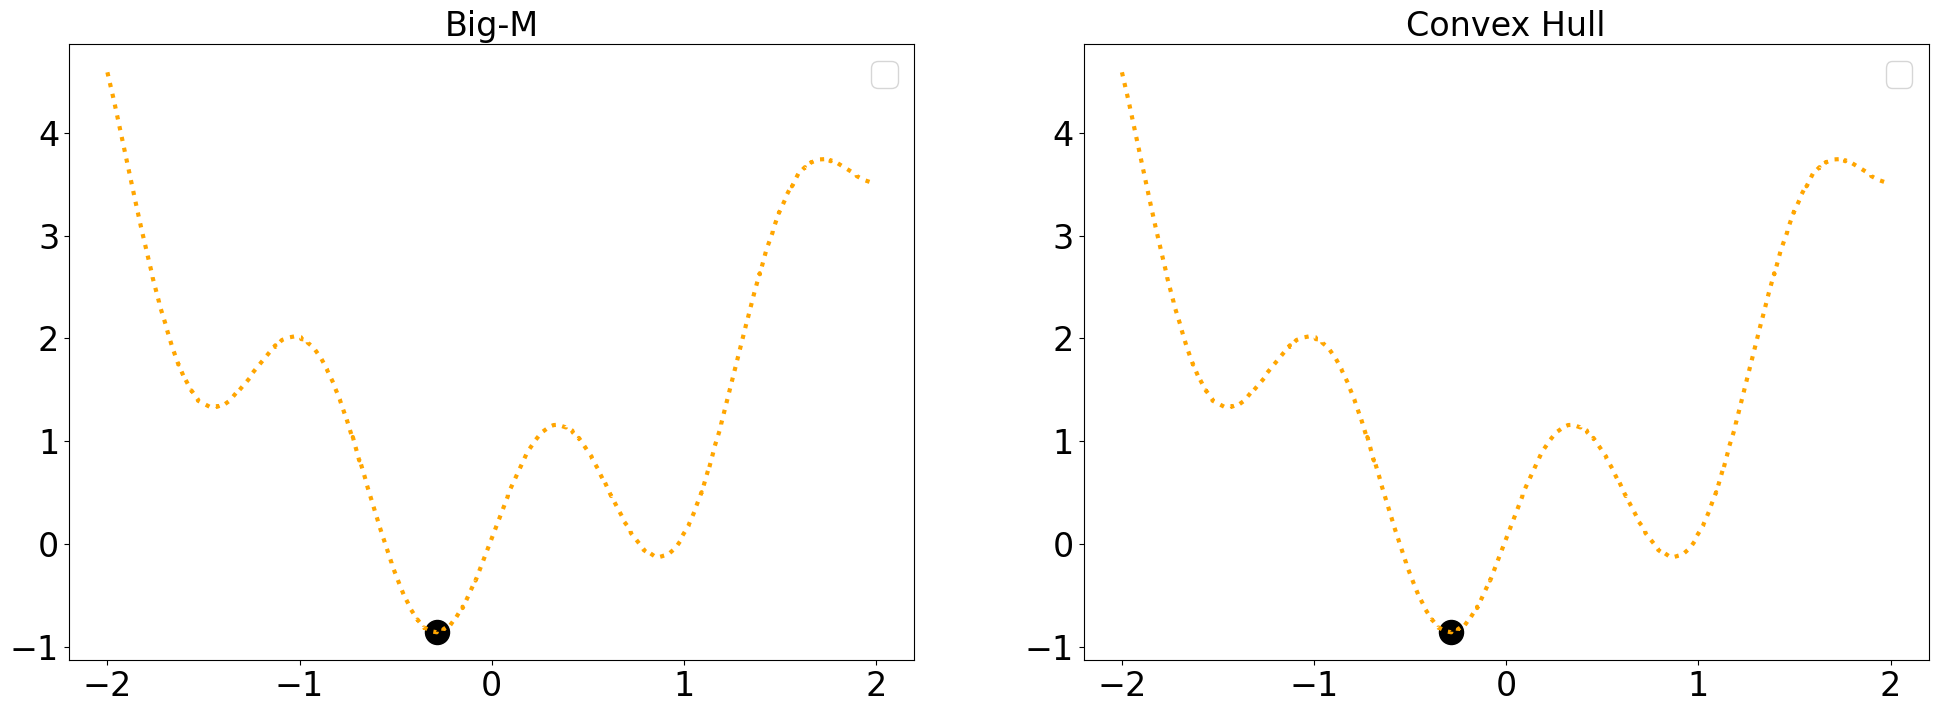

In [24]:
#create a plot with 3 subplots
fig,axs = plt.subplots(1,2,figsize = (24,8))

#Big-M Transformation
axs[0].plot(x,y_predict_lt,linewidth = 3.0,linestyle="dotted",color = "orange")
axs[0].set_title("Big-M")
axs[0].scatter([solution_1_bigm[0]],[solution_1_bigm[1]],color = "black",s = 300)
axs[0].legend()

#Hull Transformation
axs[1].plot(x,y_predict_lt,linewidth = 3.0,linestyle="dotted",color = "orange")
axs[1].set_title("Convex Hull")
axs[1].scatter([solution_2_hull[0]],[solution_2_hull[1]],color = "black",s = 300)
axs[1].legend()